# Variance Scanning (Variance of Distance to Center)

Cost definition 1: (sum of variance in each dimension)

$$

\mathrm{Cost}(d, t) := \left(\frac{N_l}{N}\right)^\gamma \mathbb E \left[ (\mathbf x - \bar{\mathbf x})^2: x_d \le t \right] + \left(\frac{N_r}{N}\right)^\gamma \mathbb E \left[ (\mathbf x - \bar{\mathbf x})^2: x_d > t \right], \quad \text{where} \quad d \in \{1, 2, 3\}, \quad t \in \mathbb{R}.

$$

Cost definition 2: (product of variance in each dimension)

$$

\mathrm{Cost}(d, t) := \left(\frac{N_l}{N}\right)^\gamma \prod_{i=1}^3 \sqrt{\mathbb E \left[ (x_i - \bar{x_i})^2: x_d \le t \right]} + \left(\frac{N_r}{N}\right)^\gamma \prod_{i=1}^3 \sqrt{\mathbb E \left[ (x_i - \bar{x_i})^2: x_d > t \right]}
, \quad \text{where} \quad d \in \{1, 2, 3\}, \quad t \in \mathbb{R}.

$$

Intuition: measuring the volume of the ellipsoid that contains the data points.

Maybe: should use the determinant of the covariance matrix instead of the product of variances to account for skewness.

The parameter gamma is there to penalize the unbalencedness of the split. The higer the gamma, the more balanced the split will be.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
epsilon = 1e-3

def noisy(data, noise_std=0.01):
    return data + np.random.normal(0, noise_std, data.shape)

def child_cost(data):
    return np.maximum(np.std(data, ddof=1, axis=0), epsilon).prod()

def sort_by_dim(data, dim):
    return data[np.argsort(data[:,dim])]

def cost_at_split(data, split, dim, gamma=1):
    left = data[data[:,dim] < split]
    right = data[data[:,dim] >= split]
    return (len(left)/len(data))**gamma * child_cost(left) + (len(right)/len(data))**gamma * child_cost(right)

def variance_scan(data, dim, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    best_cost = np.inf
    best_index = None
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        cost = (i/N)**gamma * child_cost(data[:i]) + ((N-i)/N)**gamma * child_cost(data[i:])
        if cost < best_cost:
            best_cost = cost
            best_index = i
    assert best_index is not None
    best_split = (data[best_index,dim] + data[best_index-1,dim]) / 2
    return best_split, best_cost

def variance_scan_welford(data, dim, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    # Welford's online algorithm for variance
    lMean = np.mean(data[:min_samples_per_side], axis=0)
    lM2 = np.var(data[:min_samples_per_side], axis=0) * min_samples_per_side
    rMean = np.mean(data[min_samples_per_side:], axis=0)
    rM2 = np.var(data[min_samples_per_side:], axis=0) * (N - min_samples_per_side)
    
    best_cost = np.inf
    best_index = None
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        x = data[i]
        lVar = lM2 / (i - 1)
        rVar = rM2 / (N - i - 1)
        lCost = np.maximum(np.sqrt(np.maximum(lVar, 0)), epsilon).prod()
        rCost = np.maximum(np.sqrt(np.maximum(rVar, 0)), epsilon).prod()
        cost = (i/N)**gamma * lCost + ((N-i)/N)**gamma * rCost
        if cost < best_cost:
            best_cost = cost
            best_index = i
            
        # Update statistics
        delta = x - lMean
        lMean += delta / (i+1)
        delta2 = x - lMean
        lM2 += delta * delta2
        
        delta2 = x - rMean
        rMean = ((N-i) * rMean - x) / (N-i-1)
        delta = x - rMean
        rM2 -= delta * delta2
    
    assert best_index is not None
    best_split = (data[best_index,dim] + data[best_index-1,dim]) / 2
    return best_split, best_cost

def variance_scan_all(data, gamma=1, min_samples_per_side=2):
    ndim = data.shape[1]
    splits = np.zeros(ndim)
    costs = np.zeros(ndim)
    for dim in range(ndim):
        splits[dim], costs[dim] = variance_scan_welford(data, dim, gamma, min_samples_per_side)
        # splits[dim], costs[dim] = variance_scan(data, dim, gamma, min_samples_per_side)
    return splits, costs

def cost_curve(data, dim, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    costs = np.zeros((N,))
    # Welford's online algorithm for variance
    lMean = np.mean(data[:min_samples_per_side], axis=0)
    lM2 = np.var(data[:min_samples_per_side], axis=0) * min_samples_per_side
    rMean = np.mean(data[min_samples_per_side:], axis=0)
    rM2 = np.var(data[min_samples_per_side:], axis=0) * (N - min_samples_per_side)
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        x = data[i]
        lVar = lM2 / (i - 1)
        rVar = rM2 / (N - i - 1)
        lCost = np.maximum(np.sqrt(np.maximum(lVar, 0)), epsilon).prod()
        rCost = np.maximum(np.sqrt(np.maximum(rVar, 0)), epsilon).prod()
        costs[i] = (i/N)**gamma * lCost + ((N-i)/N)**gamma * rCost
            
        # Update statistics
        delta = x - lMean
        lMean += delta / (i+1)
        delta2 = x - lMean
        lM2 += delta * delta2
        
        delta2 = x - rMean
        rMean = ((N-i) * rMean - x) / (N-i-1)
        delta = x - rMean
        rM2 -= delta * delta2
    
    splits = (data[min_samples_per_side - 1: N - min_samples_per_side, dim] + data[min_samples_per_side: N - min_samples_per_side + 1, dim]) / 2
    return splits, costs[min_samples_per_side: N - min_samples_per_side + 1]

def cost_curve_all(data, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    split_curves = np.zeros((ndim, N - 2*min_samples_per_side + 1))
    cost_curves = np.zeros_like(split_curves)
    for dim in range(ndim):
        split_curves[dim], cost_curves[dim] = cost_curve(data, dim, gamma, min_samples_per_side)
    return split_curves, cost_curves

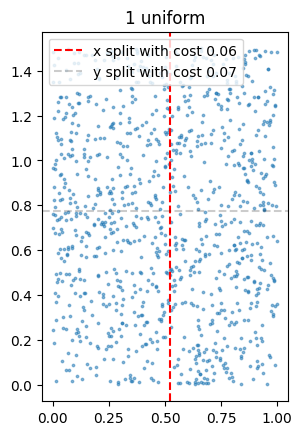

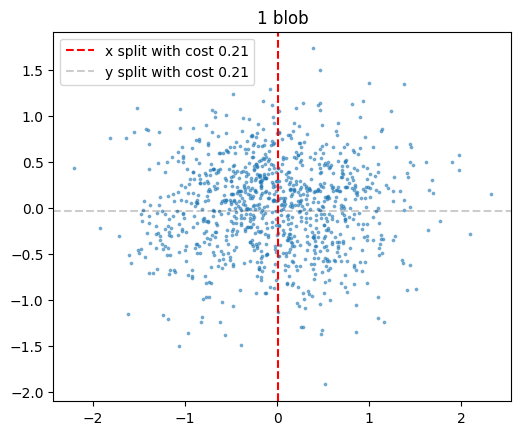

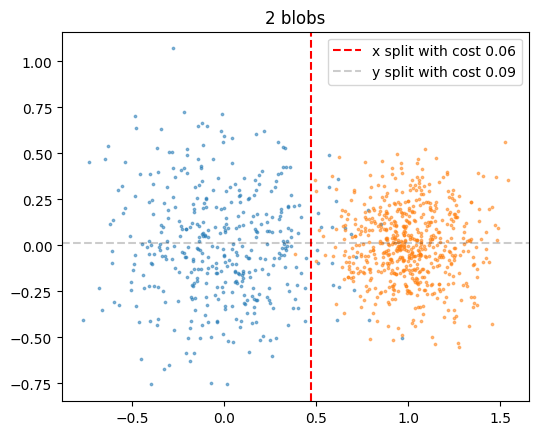

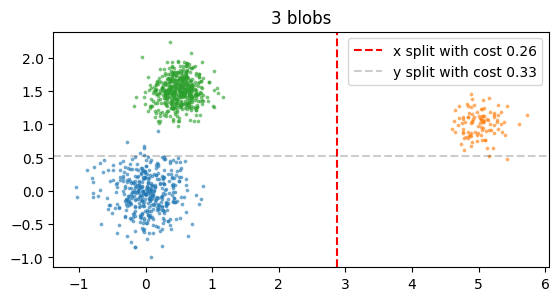

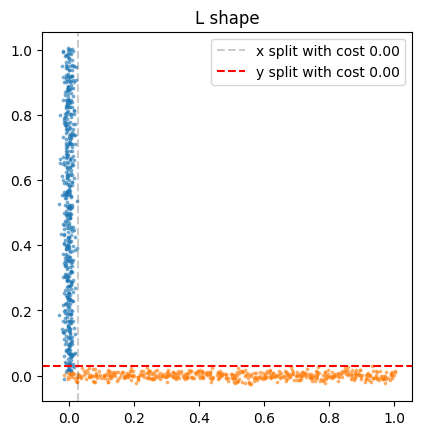

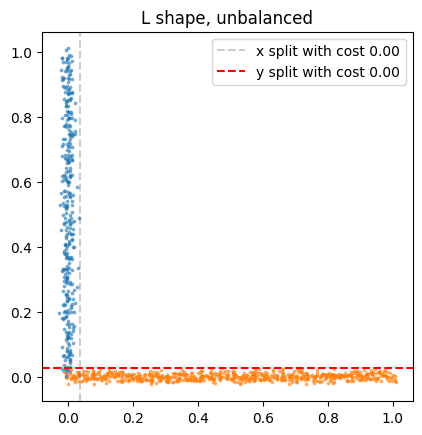

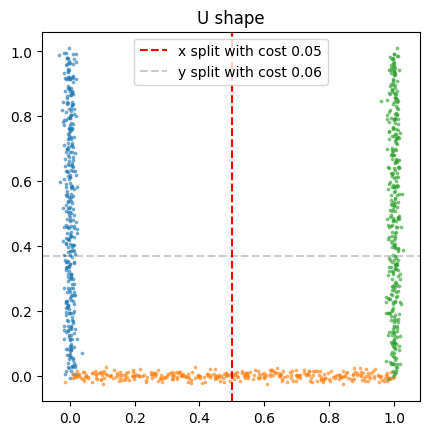

In [69]:
# 2D experiments

num_samples = 1000
# np.random.seed(42)
dataset = [
    ('1 uniform', [
        np.random.uniform((0, 0), (1, 1.5), size=(num_samples, 2)),
    ]),
    ('1 blob', [
        np.random.normal((0, 0), (0.7, 0.5), size=(num_samples, 2)),
    ]),
    ('2 blobs', [
        np.random.normal((0, 0), (0.3, 0.3), size=(num_samples * 4 // 10, 2)),
        np.random.normal((1, 0), (0.2, 0.2), size=(num_samples * 6 // 10, 2)),
    ]),
    ('3 blobs', [
        np.random.normal((0, 0), (0.3, 0.3), size=(num_samples * 4 // 10, 2)),
        np.random.normal((5, 1), (0.2, 0.2), size=(num_samples * 1 // 10, 2)),
        np.random.normal((0.5, 1.5), (0.2, 0.2), size=(num_samples * 5 // 10, 2)),
    ]),
    ('L shape', [
        noisy(np.linspace((0, 0), (0, 1), num_samples * 1 // 2)),
        noisy(np.linspace((0, 0), (1, 0), num_samples * 1 // 2)),
    ]),
    ('L shape, unbalanced', [
        noisy(np.linspace((0, 0), (0, 1), num_samples * 1 // 3)),
        noisy(np.linspace((0, 0), (1, 0), num_samples * 2 // 3)),
    ]),
    ('U shape', [
        noisy(np.linspace((0, 0), (0, 1), num_samples * 1 // 3)),
        noisy(np.linspace((0, 0), (1, 0), num_samples * 1 // 3)),
        noisy(np.linspace((1, 0), (1, 1), num_samples * 1 // 3)),
    ])
]

for name, groups in dataset:
    X = np.concatenate(groups)

    splits, costs = variance_scan_all(X, gamma=1)  # TODO can adjust gamma and min_samples_per_side
    best_dim = np.argmin(costs)

    plt.figure()
    for group in groups:
        plt.scatter(group[:, 0], group[:, 1], alpha=0.5, s=3)
    if best_dim == 0:
        plt.axvline(splits[0], color='r', linestyle='--', label=f'x split with cost {costs[0]:.2f}')
        plt.axhline(splits[1], color='k', linestyle='--', label=f'y split with cost {costs[1]:.2f}', alpha=0.2)
    else:
        plt.axvline(splits[0], color='k', linestyle='--', label=f'x split with cost {costs[0]:.2f}', alpha=0.2)
        plt.axhline(splits[1], color='r', linestyle='--', label=f'y split with cost {costs[1]:.2f}')
    plt.gca().set_aspect(1)
    plt.legend()
    plt.title(name)
    plt.show()

In [15]:
# Load 3D sample data from disk
sample_dir = "data/torus-samples-vs3d"
iteration = 2
position = np.load(f"{sample_dir}/position-{iteration}.npy")
direction = np.load(f"{sample_dir}/direction-{iteration}.npy")
weight = np.load(f"{sample_dir}/weight-{iteration}.npy")
assert position.shape[0] == direction.shape[0] == weight.shape[0]
print(f"Loaded {position.shape[0]} samples")
num_samples = min(10000, position.shape[0])
selected_indices = np.random.choice(position.shape[0], num_samples, replace=False)
position = position[selected_indices]
direction = direction[selected_indices]
weight = weight[selected_indices]
print(f"Using {num_samples} samples")
position[:, 1] *= -1
direction[:, 1] *= -1
roi = None

Loaded 687278 samples
Using 10000 samples


In [72]:
%matplotlib widget
from ipywidgets import AppLayout, FloatSlider, VBox, HBox

plt.close('all')
plt.ioff()

bounds = np.stack([position.min(axis=0), position.max(axis=0)], axis=1) # 3x2
extent = bounds[:, 1] - bounds[:, 0]
bounds += np.array([-0.1, 0.1])[None, :] * extent[:, None]
if roi is None:
    roi = np.array([[-8.64396667,  8.14603333],
        [-2.69104407,  1.94895593],
        [-8.61017197,  8.60982803]])
slider_xmin = FloatSlider(orientation='horizontal', value=roi[0, 0], min=bounds[0, 0], max=bounds[0, 1], step=0.01, description='xmin:')
slider_xmax = FloatSlider(orientation='horizontal', value=roi[0, 1], min=bounds[0, 0], max=bounds[0, 1], step=0.01, description='xmax:')
slider_ymin = FloatSlider(orientation='horizontal', value=roi[1, 0], min=bounds[1, 0], max=bounds[1, 1], step=0.01, description='ymin:')
slider_ymax = FloatSlider(orientation='horizontal', value=roi[1, 1], min=bounds[1, 0], max=bounds[1, 1], step=0.01, description='ymax:')
slider_zmin = FloatSlider(orientation='horizontal', value=roi[2, 0], min=bounds[2, 0], max=bounds[2, 1], step=0.01, description='zmin:')
slider_zmax = FloatSlider(orientation='horizontal', value=roi[2, 1], min=bounds[2, 0], max=bounds[2, 1], step=0.01, description='zmax:')

fig, (ax, axXOY, axZOY) = plt.subplots(1, 3, figsize=(13, 5))
ax.scatter(position[:, 0], position[:, 2], c=weight, s=2, alpha=0.2)
focusXOZ = ax.plot([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]], [roi[2, 0], roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0]], 'r--')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
axXOY.scatter(position[:, 0], position[:, 1], c=weight, s=2, alpha=0.2)
focusXOY = axXOY.plot([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]], [roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]], 'r--')
axXOY.set_xlabel('x')
axXOY.set_ylabel('y')
axXOY.set_aspect('equal')
axZOY.scatter(position[:, 2], position[:, 1], c=weight, s=2, alpha=0.2)
focusZOY = axZOY.plot([roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0], roi[2, 0]], [roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]], 'r--')
axZOY.set_xlabel('z')
axZOY.set_ylabel('y')
axZOY.set_aspect('equal')
plt.tight_layout()

def make_callback(i, j):
    def update_focus(change):
        roi[i, j] = change.new
        focusXOZ[0].set_xdata([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]])
        focusXOZ[0].set_ydata([roi[2, 0], roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0]])
        focusXOY[0].set_xdata([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]])
        focusXOY[0].set_ydata([roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]])
        focusZOY[0].set_xdata([roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0], roi[2, 0]])
        focusZOY[0].set_ydata([roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]])
        fig.canvas.draw()
        # fig.canvas.flush_events()
    return update_focus

slider_xmin.observe(make_callback(0, 0), names='value')
slider_xmax.observe(make_callback(0, 1), names='value')
slider_ymin.observe(make_callback(1, 0), names='value')
slider_ymax.observe(make_callback(1, 1), names='value')
slider_zmin.observe(make_callback(2, 0), names='value')
slider_zmax.observe(make_callback(2, 1), names='value')

for slider in [slider_xmin, slider_xmax, slider_ymin, slider_ymax, slider_zmin, slider_zmax]:
    slider.layout.width = '40%'

AppLayout(
    center=fig.canvas,
    footer=VBox([HBox([slider_xmin, slider_xmax]), HBox([slider_ymin, slider_ymax]), HBox([slider_zmin, slider_zmax])]),
)

AppLayout(children=(VBox(children=(HBox(children=(FloatSlider(value=-17.276551361083982, description='xmin:', …

Current focus:
[[-8.60655136  1.43344864]
 [-1.95104527 13.38282585]
 [24.96718155 51.57718155]]
Splits: [-3.84731627 -1.82821512 35.62199402]
Costs: [0.01112889 0.02187152 0.01118996]
Best split dimension: 0


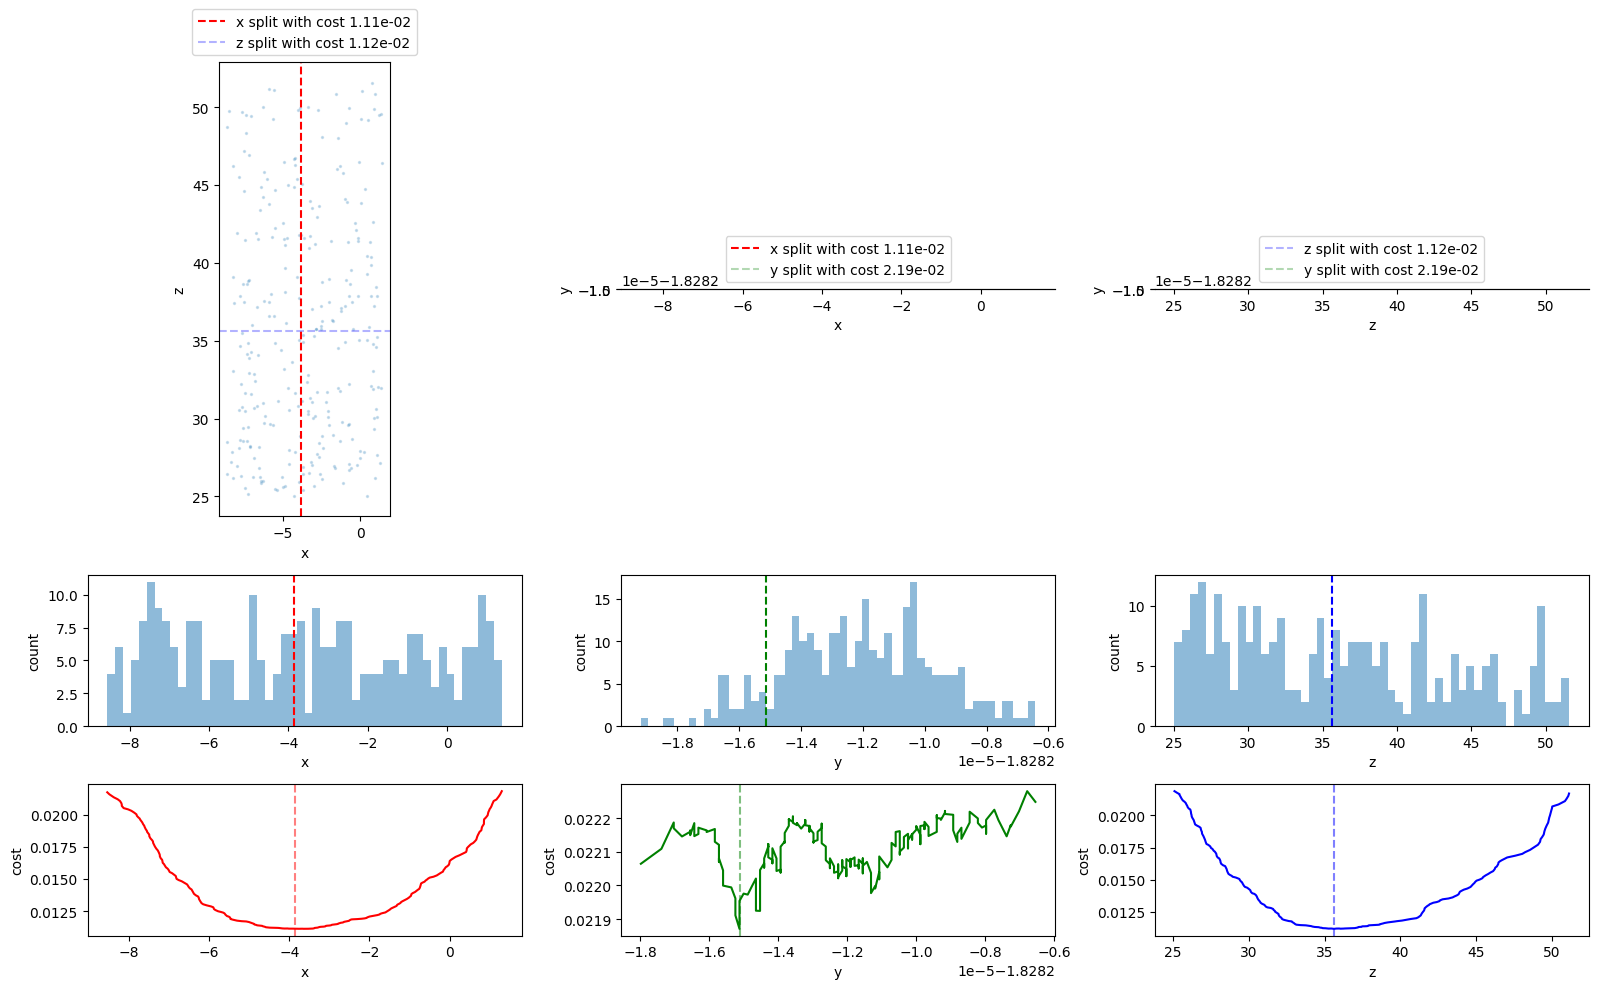

In [73]:
# Plot the focused samples, split locations, cost curves, and histograms

plt.close('all')
%matplotlib inline
print("Current focus:")
print(roi)

gamma = 1
mask = (position[:, 0] >= roi[0, 0]) & (position[:, 0] <= roi[0, 1]) & (position[:, 1] >= roi[1, 0]) & (position[:, 1] <= roi[1, 1]) & (position[:, 2] >= roi[2, 0]) & (position[:, 2] <= roi[2, 1])
X = position[mask]
split_curves, cost_curves = cost_curve_all(X, gamma=gamma)
# costs = cost_curves.min(axis=1)
# splits = np.array([split_curves[i, cost_curves[i].argmin()] for i in range(3)])
splits, costs = variance_scan_all(X, gamma=gamma)
best_dim = np.argmin(costs)
best_split = splits[best_dim]
print("Splits:", splits)
print("Costs:", costs)
print(f"Best split dimension: {best_dim}")

fig, axes = plt.subplots(3, 3, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1, 1]})
(axesSample, axesHist, axesCurve) = axes
for ax, (hdim, vdim) in zip(axesSample, [(0, 2), (0, 1), (2, 1)]):
    hcolor = ['r', 'g', 'b'][hdim]
    vcolor = ['r', 'g', 'b'][vdim]
    hname = ['x', 'y', 'z'][hdim]
    vname = ['x', 'y', 'z'][vdim]
    ax.scatter(X[:, hdim], X[:, vdim], s=2, alpha=0.2)
    ax.axvline(splits[hdim], color=hcolor, linestyle='--', label=f'{hname} split with cost {costs[hdim]:.2e}', alpha=1.0 if hdim == best_dim else 0.3)
    ax.axhline(splits[vdim], color=vcolor, linestyle='--', label=f'{vname} split with cost {costs[vdim]:.2e}', alpha=1.0 if vdim == best_dim else 0.3)
    ax.set_xlabel(hname)
    ax.set_ylabel(vname)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_aspect('equal')

for dim, ax in enumerate(axesHist):
    ax.hist(X[:, dim], bins=50, alpha=0.5)
    split = splits[dim]
    dim_name = ['x', 'y', 'z'][dim]
    color = ['r', 'g', 'b'][dim]
    ax.axvline(split, color=color, linestyle='--')
    ax.set_xlabel(dim_name)
    ax.set_ylabel("count")
    ax.set_aspect('auto')
    
for dim, ax in enumerate(axesCurve):
    split = splits[dim]
    dim_name = ['x', 'y', 'z'][dim]
    color = ['r', 'g', 'b'][dim]
    ax.plot(split_curves[dim], cost_curves[dim], color=color)
    ax.axvline(split, color=color, linestyle='--', alpha=0.5)
    ax.set_xlabel(dim_name)
    ax.set_ylabel("cost")
    ax.set_aspect('auto')

plt.tight_layout()
plt.show()

In [74]:
roi.dump('output/vs/failure-2-torus-roi.npy')
# roi = np.load('output/vs/success-2-torus-roi.npy', allow_pickle=True)

In [42]:
splits[1]

-1.7472941875457764